# Sparse models for large datasets

This is a continuation of "1d_new.ipynb". For more general information about how to use the models of this package see that notebook.

One problem with Gaussian process regression is that the training of the model is of order $\mathcal{O}(N^3)$ where $N$ is the number of datapoints. Thus, for large datasets sparsification of the model is needed to keep the training process reasonably short.

For this purpose there exist the `SparseGradient`, `SparseIntegral`, and `SparseFunction` models. They are sparsified versions of the models described in the previous notebook.

We will show how to use the sparse models via the example of `SparseIntegral`. The other models work the same.

## Sparse Integration

Creating the data works the same way as for the full model. We again fit the sine function from gradient observations.

In [1]:
import jax.numpy as jnp
from jax import random

In [2]:
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [3]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
n_data = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_data = random.uniform(subkey, n_data, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02

key, subkey = random.split(key)
y_cos = cos(x_data, noise, subkey)

In [4]:
X_train = (jnp.zeros((1,1)), x_data.reshape(-1,1))
Y_train = jnp.hstack((jnp.zeros(1), y_cos))

noise_vector = jnp.hstack((0, jnp.ones(n_data)*noise))

The only difference to the full models is that we have to specify a reference set. The full data defined above is then projected onto this reference set. Via this process the sparse algorithm is of order $\mathcal{O}(N \cdot M^2)$ where $N$ is the number of datapoints, and $M$ is the number of reference points. Thus, if $M$ is chosen to be a small number, the sparse algorithm is much faster than the full model.

These reference points can be chosen any way one wants. Popular choices are
- A random subset of the full dataset,
- An even grid over the region of interest.

Here we chose an even grid.

In [5]:
from calcgp import SparseIntegral
from calcgp.kernels import RBF

kernel = RBF()

n_ref = 5
Xref = jnp.linspace(*bounds, n_ref).reshape(-1,1)

model = SparseIntegral(Xref, kernel, noise=noise_vector)

In [6]:
model.train(X_train, Y_train)

predict_grid = jnp.linspace(*bounds, 100)

int_pred, int_err = model.predict(predict_grid.reshape(-1,1))

True


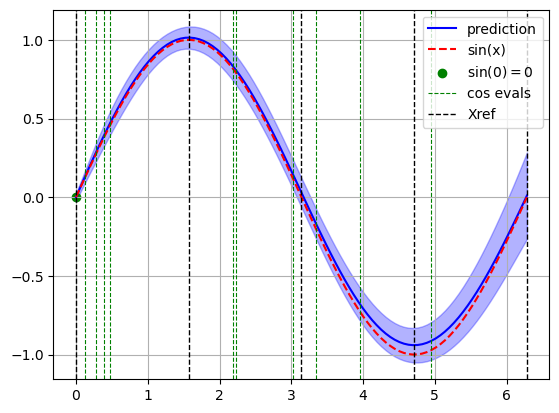

In [7]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, int_pred, c="b", label="prediction")
plt.fill_between(predict_grid, int_pred-int_err*2, int_pred+int_err*2, color="b", alpha=0.3)

plt.plot(predict_grid, sin(predict_grid), c="r", ls="--",label="sin(x)")

plt.scatter(0, 0, c="g", label="$\sin(0)=0$")
for i,x in enumerate(x_data): 
    if i == 0:
        plt.axvline(x, c="g", lw=0.8, ls="--", label="cos evals")
    else:
        plt.axvline(x, c="g", lw=0.8, ls="--")

        
for i,x in enumerate(Xref):
    if i == 0:
        plt.axvline(x, c="k", lw=1.0, ls="--", label="Xref")
    else:
        plt.axvline(x, c="k", lw=1.0, ls="--")

plt.grid()
plt.legend()

This plot shows the predicted function in blue, with the shaded area describing the 95%-confidence interval in which the true function lies. The green vertical lines represent the locations at which the gradient was observed. The black dashed lines represent the locations of the reference points.

## Optimizing the reference points

It is also possible to optimizze the locations of the reference points. This can be done by giving the sparse model the flag `optim_ref=True`.

However, this may drastically increase the training time and also does not necessarily make the prediction better. One has to just try if this option helps.

In [8]:
model = SparseIntegral(Xref, kernel, noise=noise_vector, optim_ref=True)

model.train(X_train, Y_train)

predict_grid = jnp.linspace(*bounds, 100)

int_pred, int_err = model.predict(predict_grid.reshape(-1,1))

True


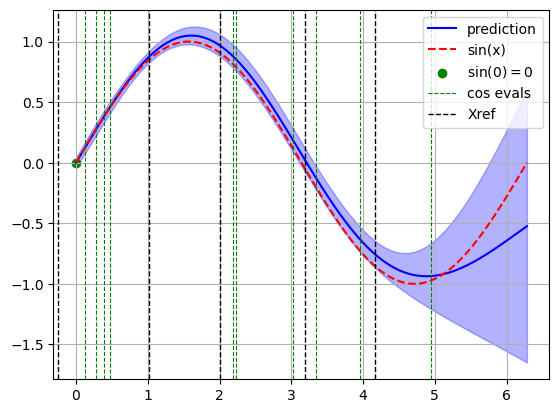

In [9]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, int_pred, c="b", label="prediction")
plt.fill_between(predict_grid, int_pred-int_err*2, int_pred+int_err*2, color="b", alpha=0.3)

plt.plot(predict_grid, sin(predict_grid), c="r", ls="--",label="sin(x)")

plt.scatter(0, 0, c="g", label="$\sin(0)=0$")
for i,x in enumerate(x_data): 
    if i == 0:
        plt.axvline(x, c="g", lw=0.8, ls="--", label="cos evals")
    else:
        plt.axvline(x, c="g", lw=0.8, ls="--")

        
for i,x in enumerate(model.Xref):
    if i == 0:
        plt.axvline(x, c="k", lw=1.0, ls="--", label="Xref")
    else:
        plt.axvline(x, c="k", lw=1.0, ls="--")

plt.grid()
plt.legend()